In [1]:
import pandas as pd
import pytz
import datetime as dt
import math
import seaborn as sns
import matplotlib as mpl
#mpl.rcParams['path.simplify'] = False
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz


# misc
import warnings

## Psychopy Related Functions

In [3]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals

## ECG: Shimmer Related Functions

In [4]:
def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp


def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df
    


## HRV: Time domain analysis

In [5]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output


def group_peaks_from_ind_to_msec(grouped_peaks_ind, sampling_freq):
    
    grouped_peak_sec = grouped_peaks_ind*(1/sampling_freq)
    grouped_peak_msec = grouped_peak_sec*1000
    
    return grouped_peak_msec


def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results



def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

## Path and files

In [6]:
psychopy_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP012_141123/Psychopy_data/VP012_141123_DigiRelax_Experiment_2023-11-14_09h47.48.508.csv"
#col_interest_psychopy = "baseline_instruction_ts"


ecg_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP012_141123/Shimmer_data/2023-11-14_09.27.59_VP012_141123_SD_Session1/VP012_141123_Session1_Shimmer_6B1E_Calibrated_SD.csv"
ecg_col_name = "Shimmer_6B1E_ECG_LL-LA_24BIT_CAL"
timestamp_shimmer_col_name = "Shimmer_6B1E_Timestamp_Unix_CAL"

## Fetching and slicing information

In [7]:
ecg_df = read_shimmer_sensor(ecg_file_path)


In [8]:
event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts", "saliva_probe_4_ts", "saliva_probe_4_ts"]
offset_min_list_new  = [[3], [5], [5,5], [5, 5, 5], [-5], [5]]

baseline_instruction_ts
{'Mean RR (ms)': 1082.2561553030303, 'STD RR/SDNN (ms)': 71.33600022485506, "Mean HR (Kubios' style) (beats/min)": 55.43974012621816, 'Mean HR (beats/min)': 55.68739082637016, 'STD HR (beats/min)': 3.770735235142822, 'Min HR (beats/min)': 48.83942766295708, 'Max HR (beats/min)': 67.81456953642385, 'RMSSD (ms)': 75.58914401837629, 'NNxx': 102, 'pNNxx (%)': 61.81818181818182}
tsst_prep_ts
{'Mean RR (ms)': 896.1802956586827, 'STD RR/SDNN (ms)': 103.04696509765334, "Mean HR (Kubios' style) (beats/min)": 66.95081368186148, 'Mean HR (beats/min)': 67.90228858890288, 'STD HR (beats/min)': 8.404533959335922, 'Min HR (beats/min)': 47.55417956656347, 'Max HR (beats/min)': 100.72131147540983, 'RMSSD (ms)': 78.17945444089997, 'NNxx': 164, 'pNNxx (%)': 49.10179640718563}
tsst_pres_ts
{'Mean RR (ms)': 845.9072651836158, 'STD RR/SDNN (ms)': 490.32254645052086, "Mean HR (Kubios' style) (beats/min)": 70.92976082546848, 'Mean HR (beats/min)': 111.37055374681009, 'STD HR (beats/min

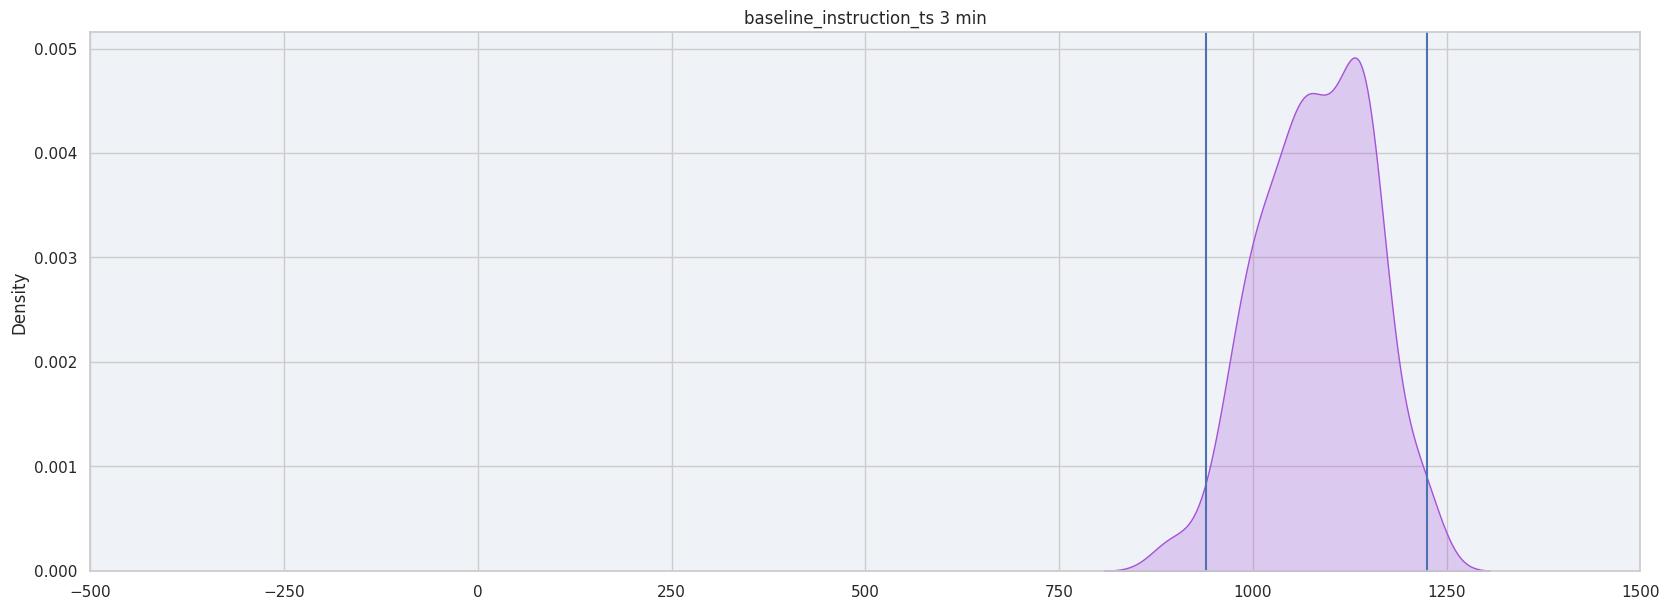

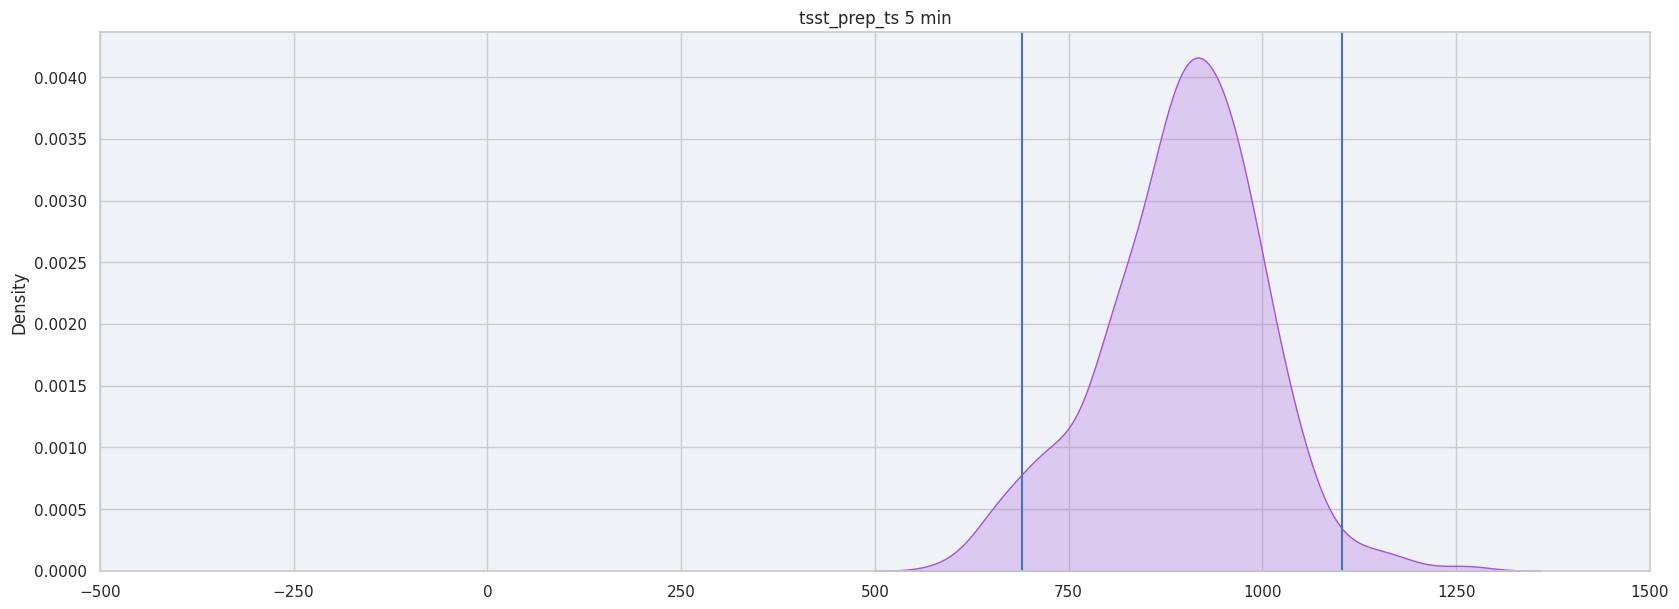

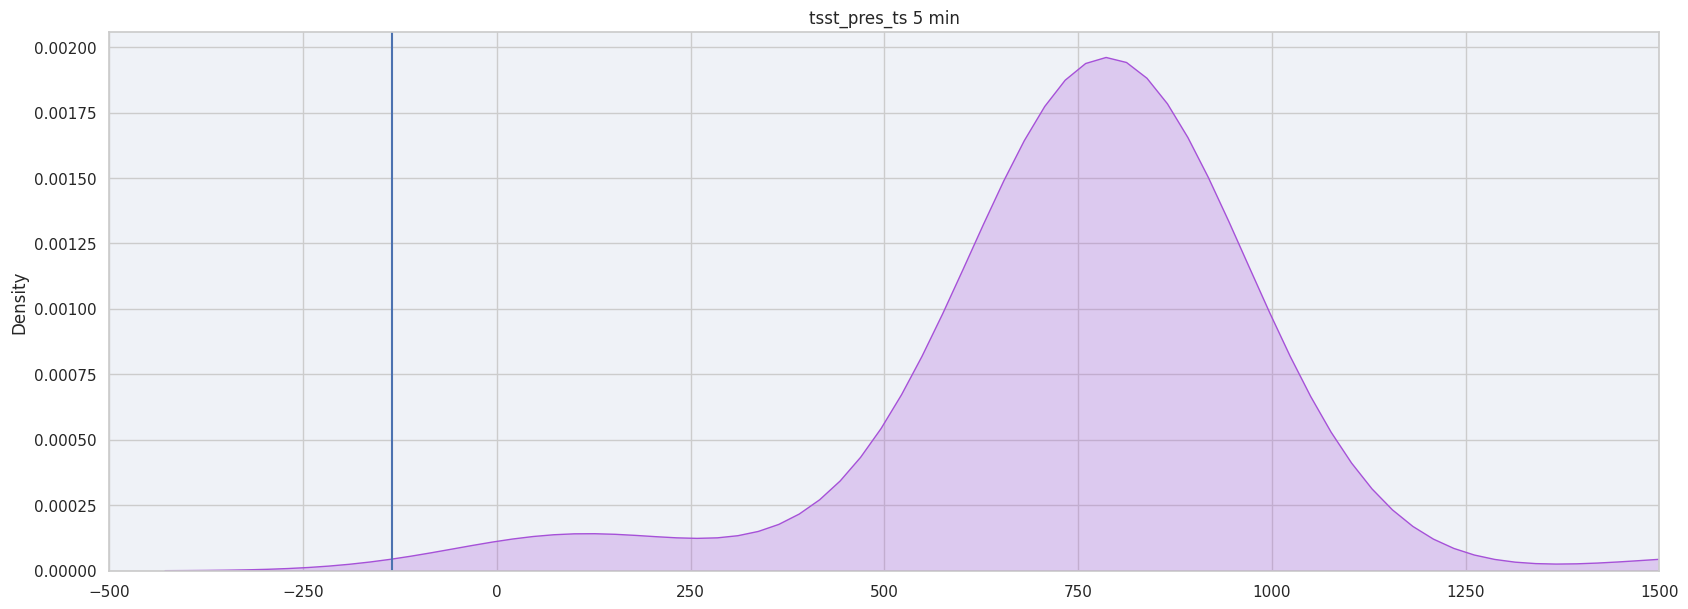

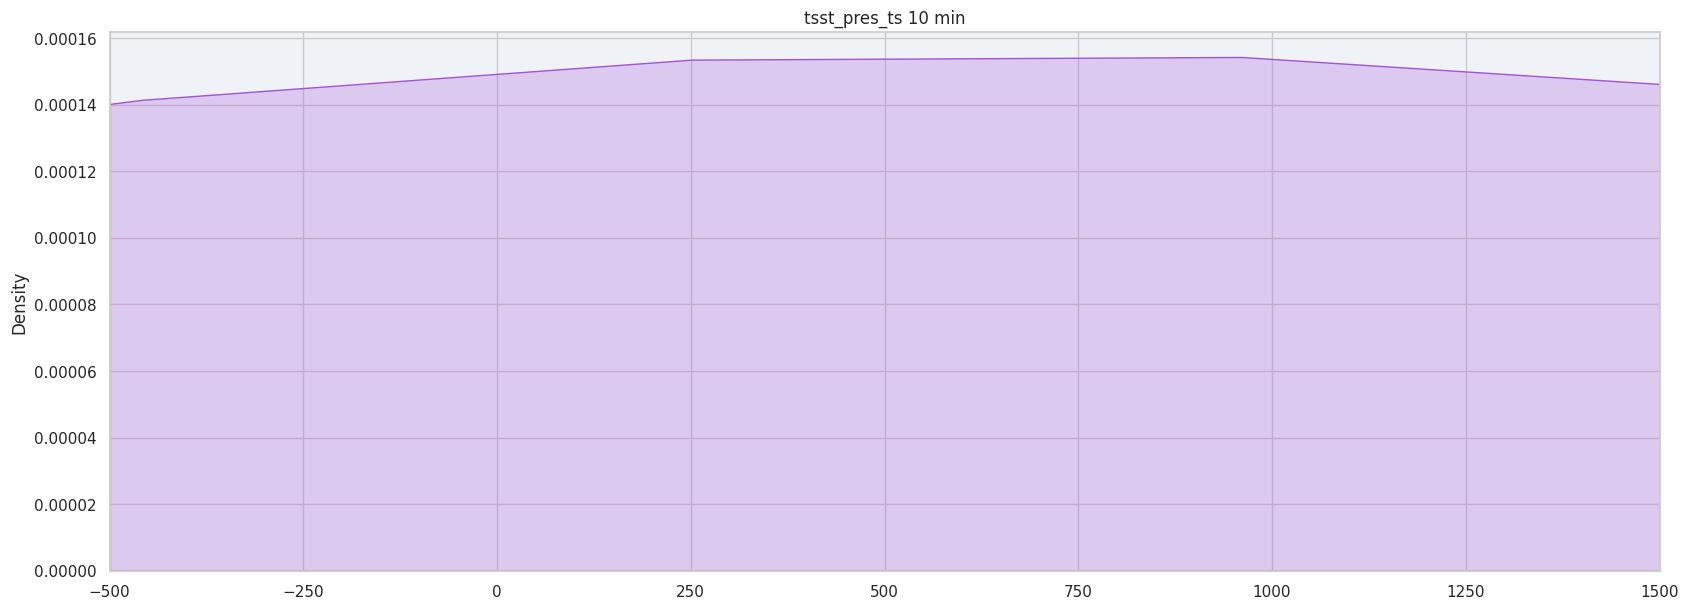

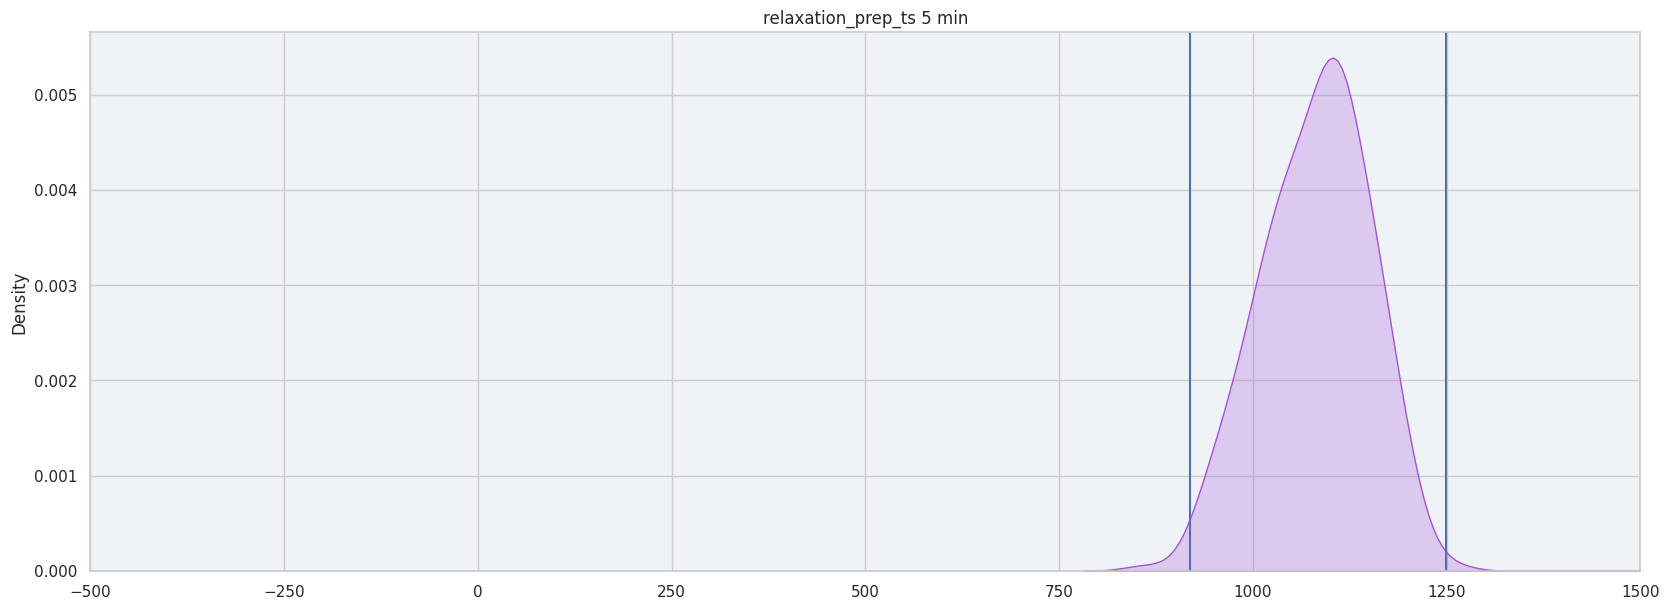

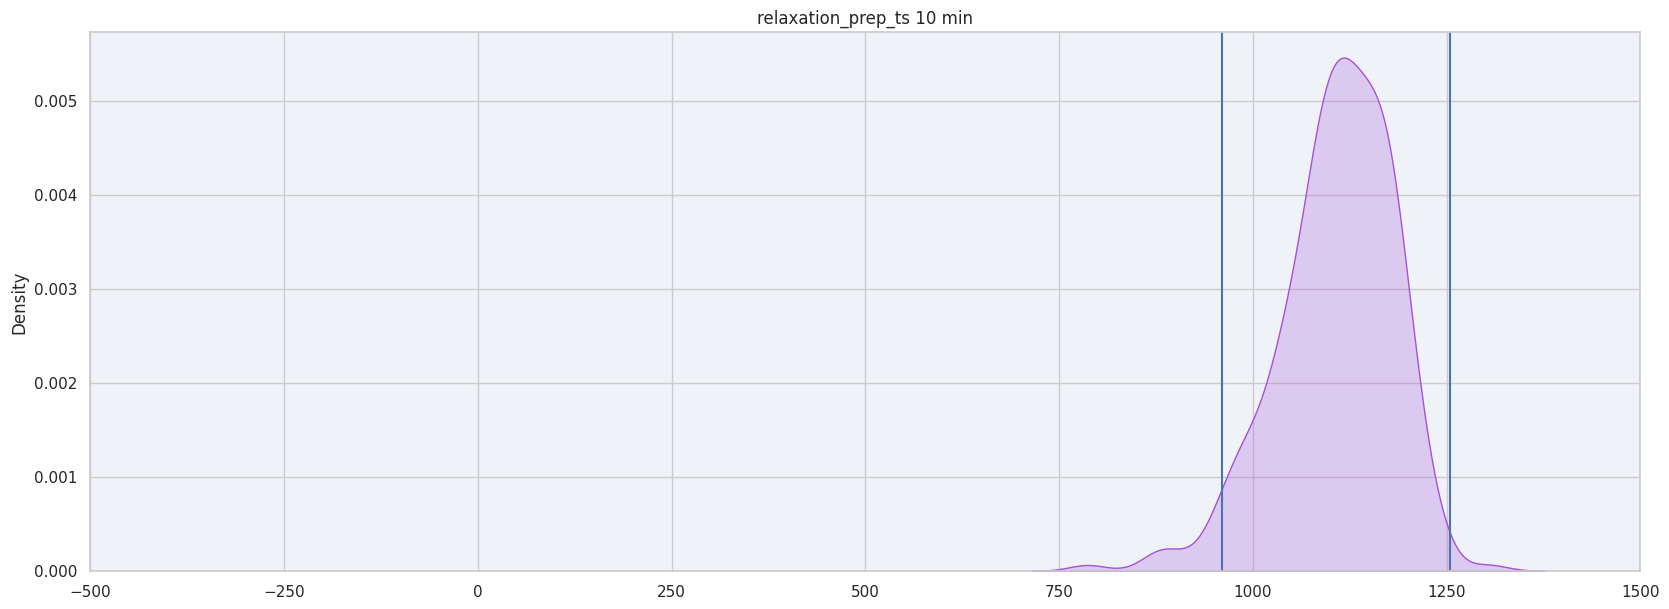

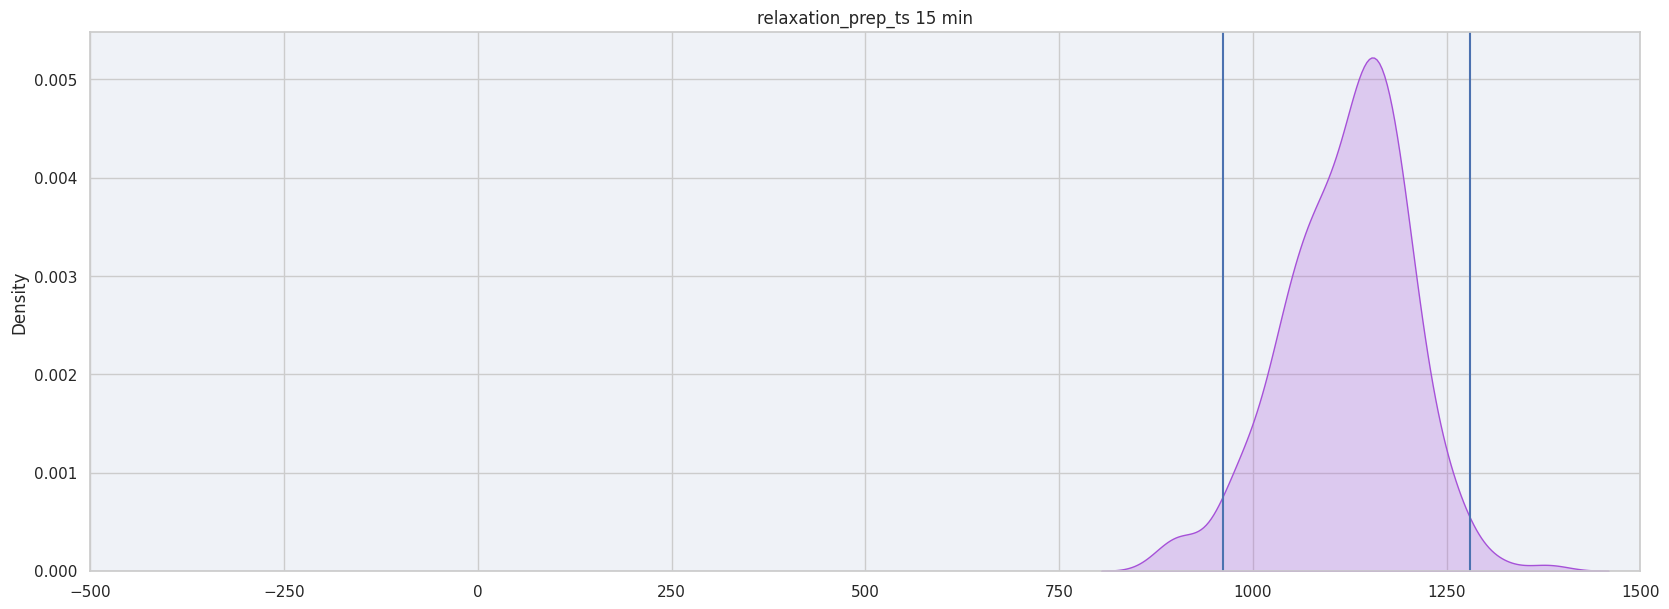

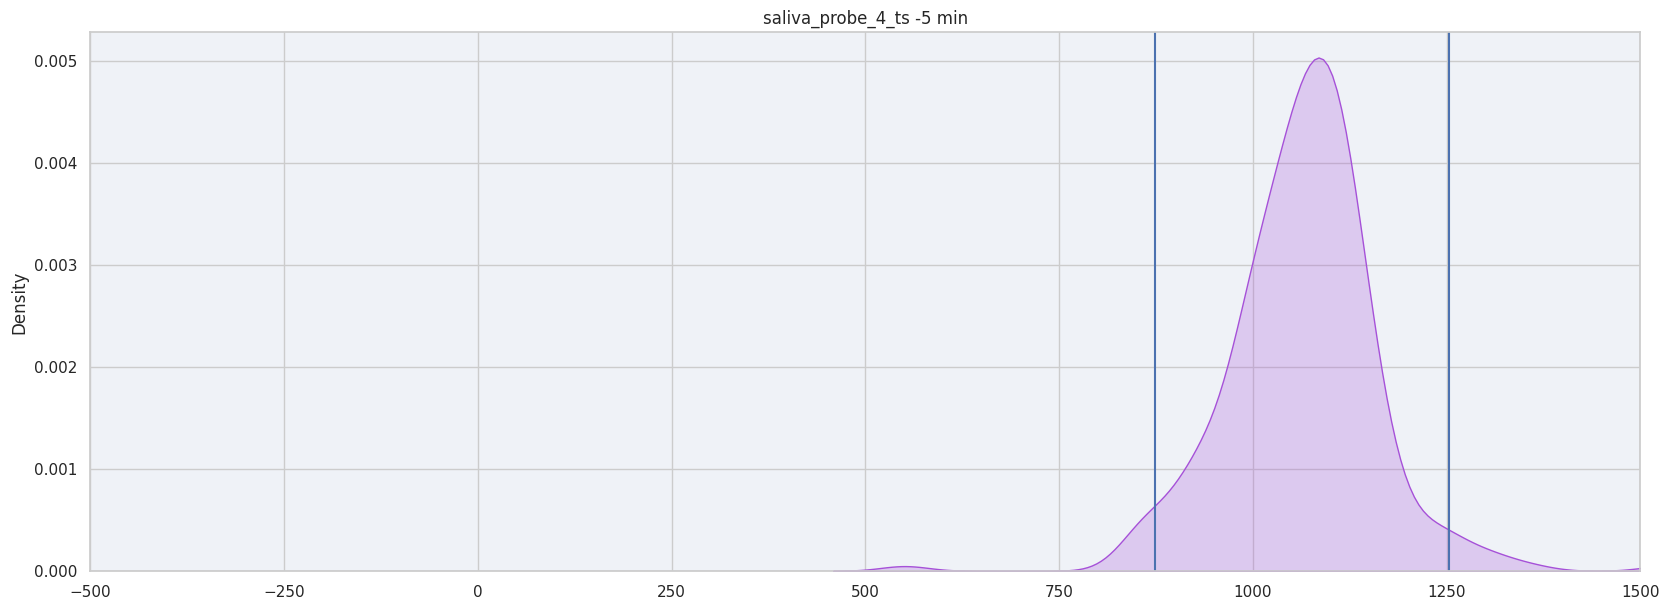

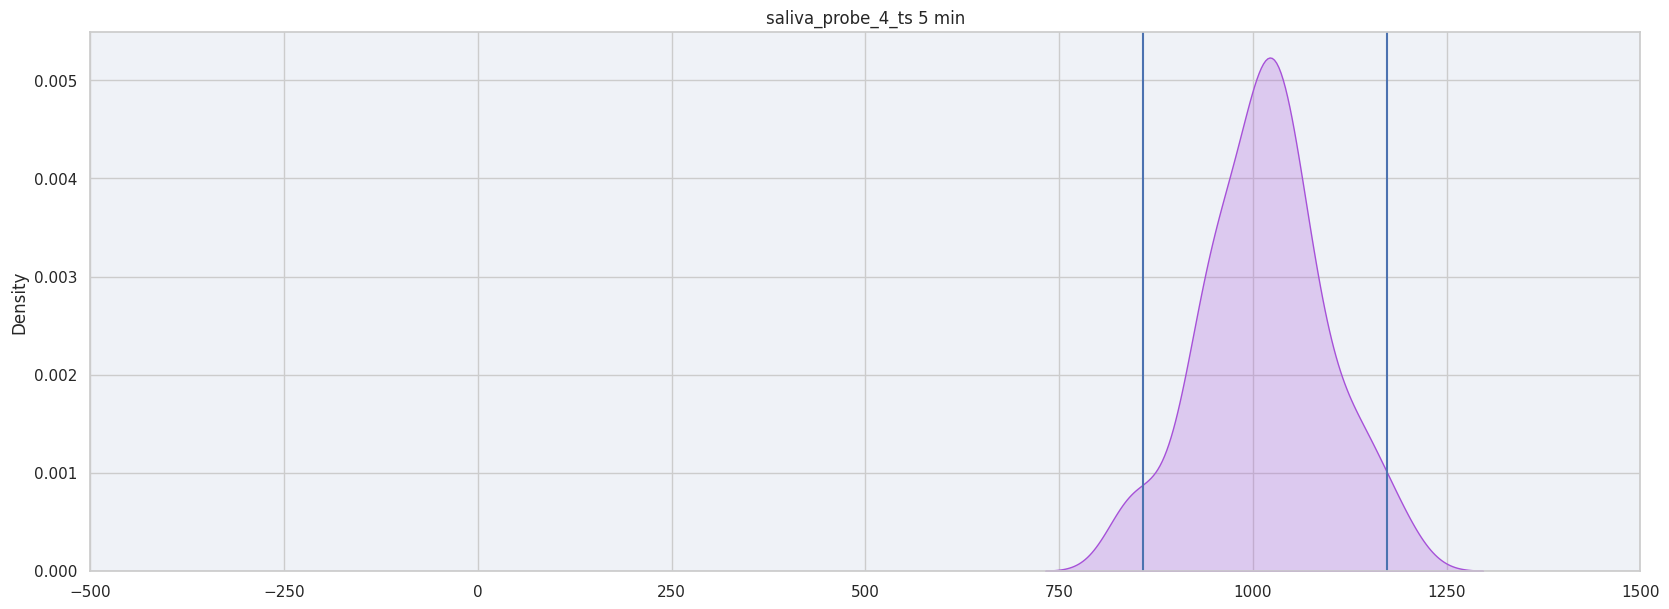

In [ ]:

#mean_cumm_list = []
#std_cumm_list  = []
#event_interets_plot = []

##---outer loop to hnadle muultiple offsets from the selected events 
psychopy_df = read_manipulate_psychopy(psychopy_file_path)


ecg_df = read_shimmer_sensor(ecg_file_path)
selected_ecg_df = ecg_df[[timestamp_shimmer_col_name, ecg_col_name]]
selected_ecg_df = selected_ecg_df.copy()
selected_ecg_df = standardize_timestamps_shimmer(selected_ecg_df, timestamp_shimmer_col_name)

selected_ecg_df=selected_ecg_df.copy()
selected_ecg_df['heartrate'] = selected_ecg_df[ecg_col_name]
selected_ecg_df=col_from_str_float (selected_ecg_df, "heartrate")

sampling_freq = 256

#fig, axs = plt.subplots(3, 3)
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

for ind, event_selected in enumerate(event_interest_list_new):

    #offset_list_selected_event = offset_min_list_new[ind]

    print(event_selected)

    current_event_timestamp = get_nonNan_list_psychopy(psychopy_df, event_selected)[0]

    offset_min_list_selected = offset_min_list_new[ind]
        
    acc_min_print = 0

    for offset_min in offset_min_list_selected:
            
        offset_min_print = offset_min + acc_min_print
            
        acc_min_print = offset_min_print

        event_plot = event_selected +" "+ str(offset_min_print) + " min"
        
        #print(event_plot)
        
        #event_interets_plot.append(event_plot)

        timestamp_offset = get_offset_timestamp(current_event_timestamp, offset_min)

        start_end_time_list = [current_event_timestamp, timestamp_offset]

        timestamp_start_slice = min(start_end_time_list)

        timestamp_end_slice = max(start_end_time_list)
        
        

        ecg_df_ii=slice_df_wrt_timestamps(selected_ecg_df, timestamp_start_slice, timestamp_end_slice, timestamp_shimmer_col_name)
        
        
        # RR-intervals are the differences between successive peaks

        # detect peaks
        peaks, similarity = detect_peaks(ecg_df_ii.heartrate, threshold=0.3)

        #group peaks
        grouped_peaks = group_peaks(peaks)
        grouped_peaks_msec=group_peaks_from_ind_to_msec(grouped_peaks, sampling_freq)
        ## RR-intervals are the differences between successive peak
        rr = np.diff(grouped_peaks_msec)
        res=timedomain(rr)
        print(res)
        
        
        
        plt.figure(figsize=(20, 7))
        plt.title(event_plot)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore") # ignore FutureWarning 
            sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)
    
   
        outlier_low = np.mean(rr) - 2 * np.std(rr)
        outlier_high = np.mean(rr) + 2 * np.std(rr)
        
        
        #plt.xlim([0, 500]) 

        plt.axvline(x=outlier_low)
        plt.axvline(x=outlier_high, label="outlier boundary")

        #plt.text(outlier_low - 175, 0.004, "outliers low (< mean - 2 sigma)", fontsize = 8)
        #plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)", fontsize = 8)
    
        plt.xlim([-500, 1500]) 
        
        current_event_timestamp = timestamp_offset

        #mean_val, std_val = mean_std_col_df(sensor_df_ii, data_col_name) 
        #mean_cumm_list.append(mean_val)
        #std_cumm_list.append(std_val)
        #event_interets_plot.append(offset_min_print)



        

In [17]:
ecg_df_ii

,Shimmer_6B1E_Timestamp_Unix_CAL,Shimmer_6B1E_ECG_LL-LA_24BIT_CAL,heartrate
1101533,1.699956e+09,-14.708124364390894,-14.708124
1101534,1.699956e+09,-14.715625013783576,-14.715625
1101535,1.699956e+09,-14.721106257570536,-14.721106
1101536,1.699956e+09,-14.73199662351568,-14.731997
1101537,1.699956e+09,-14.744834273437771,-14.744834
...,...,...,...
1128552,1.699956e+09,-14.478128490224897,-14.478128
1128553,1.699956e+09,-14.552990740894169,-14.552991
1128554,1.699956e+09,-14.625400856185063,-14.625401
1128555,1.699956e+09,-14.656918007960083,-14.656918


In [18]:
psychopy_df = read_manipulate_psychopy(psychopy_file_path)
non_nan_timestamp=get_nonNan_list_psychopy(psychopy_df, col_interest_psychopy)
start_timestamp = non_nan_timestamp[0]

## offset time in min

stop_timestamp = get_offset_timestamp(start_timestamp, time_offset)

NameError: name 'col_interest_psychopy' is not defined

In [ ]:
print(start_timestamp)
print(stop_timestamp)

In [ ]:
time_zone = 'Europe/Berlin'
tz = pytz.timezone(time_zone)
    
start_time = dt.datetime.fromtimestamp(start_timestamp, tz)
end_time  = dt.datetime.fromtimestamp(stop_timestamp, tz)

In [ ]:
ecg_df = read_shimmer_sensor(ecg_file_path)
selected_ecg_df = ecg_df[[timestamp_shimmer_col_name, ecg_col_name]]
selected_ecg_df = selected_ecg_df.copy()
selected_ecg_df=standardize_timestamps_shimmer(selected_ecg_df, timestamp_shimmer_col_name)
sliced_ecg_df=slice_df_wrt_timestamps(selected_ecg_df, start_timestamp, stop_timestamp, timestamp_shimmer_col_name)

In [ ]:
sliced_ecg_df=sliced_ecg_df.copy()
sliced_ecg_df['heartrate'] = sliced_ecg_df[ecg_col_name]
sliced_ecg_df=col_from_str_float (sliced_ecg_df, "heartrate")

## HRV analysis 

In [ ]:
# RR-intervals are the differences between successive peaks

# detect peaks
peaks, similarity = detect_peaks(sliced_ecg_df.heartrate, threshold=0.3)
#sliced_ecg_df[start:stop].index, sliced_ecg_df[start:stop].heartrate
#peaks, similarity = detect_peaks(sliced_ecg_df[start:stop].heartrate, threshold=0.3)
#group peaks
grouped_peaks = group_peaks(peaks)
## RR-intervals are the differences between successive peak
rr = np.diff(grouped_peaks)

In [ ]:
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})
plt.figure(figsize=(20, 7))
plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8")
plt.show()

Text(453.26403231017366, 0.004, 'outliers high (> mean + 2 sigma)')

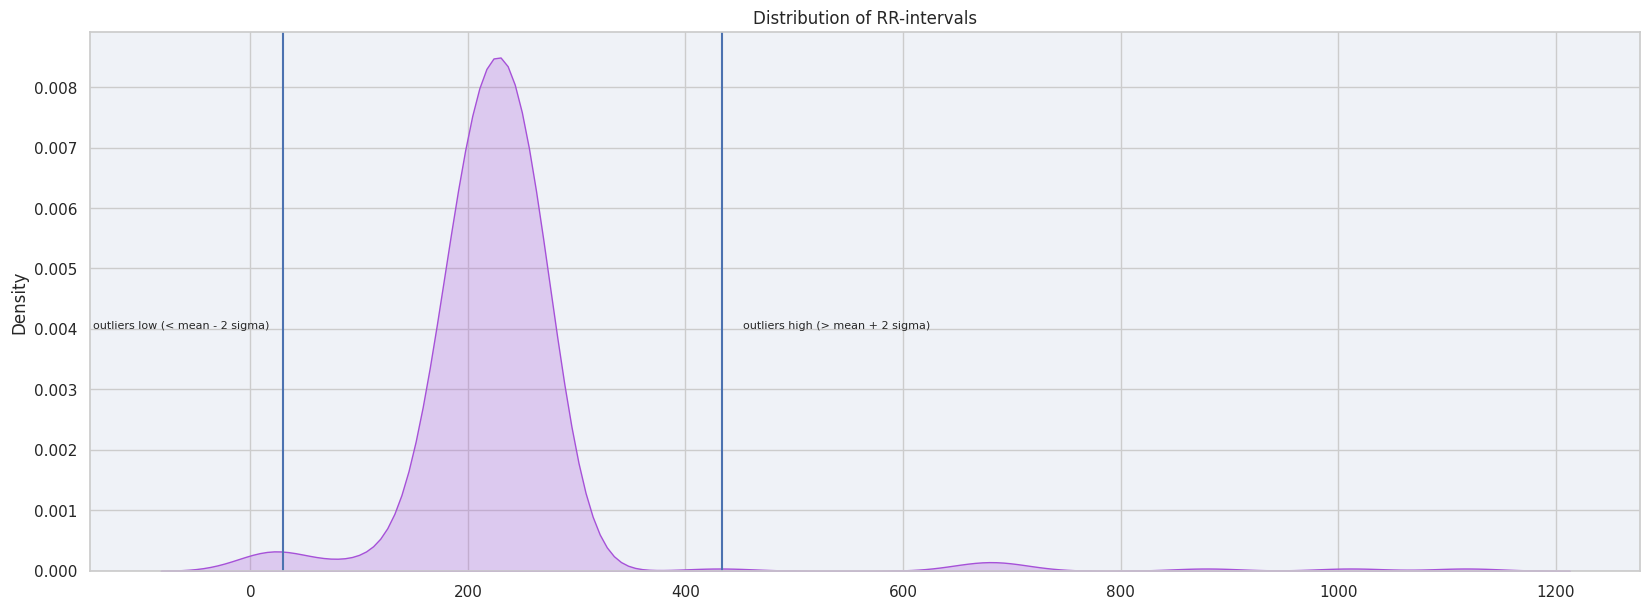

In [49]:
plt.figure(figsize=(20, 7))
plt.title("Distribution of RR-intervals")

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore FutureWarning 
    sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)
    
   
outlier_low = np.mean(rr) - 2 * np.std(rr)
outlier_high = np.mean(rr) + 2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")

plt.text(outlier_low - 175, 0.004, "outliers low (< mean - 2 sigma)", fontsize = 8)
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)", fontsize = 8)

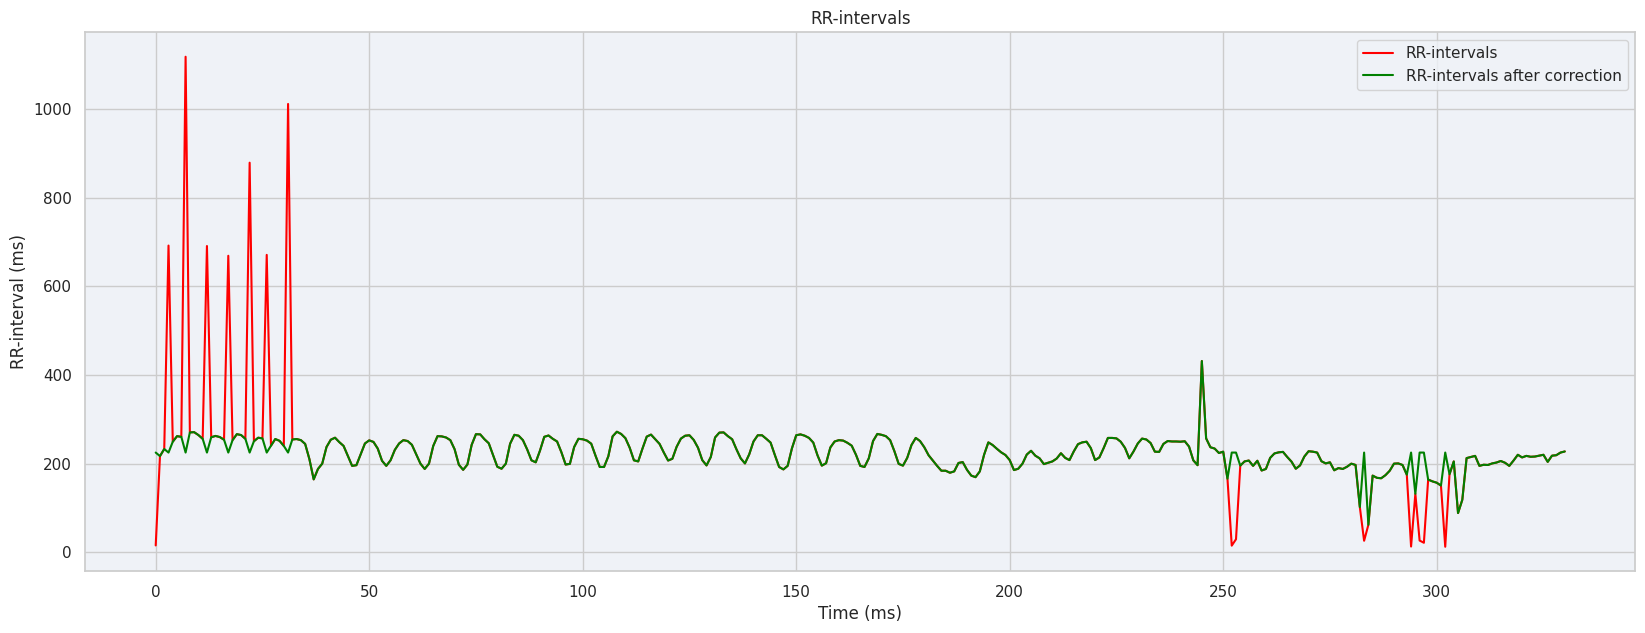

In [50]:
plt.figure(figsize=(20, 7))

rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(rr, color="red", label="RR-intervals")
plt.plot(rr_corrected, color="green",  label="RR-intervals after correction")
plt.legend()
plt.show()

In [51]:
results = timedomain(rr)

In [52]:
results

{'Mean RR (ms)': 231.63141993957703,
 'STD RR/SDNN (ms)': 100.81630618529833,
 "Mean HR (Kubios' style) (beats/min)": 259.03221599060913,
 'Mean HR (beats/min)': 345.8342628806097,
 'STD HR (beats/min)': 502.24696348262495,
 'Min HR (beats/min)': 53.66726296958855,
 'Max HR (beats/min)': 4800.0,
 'RMSSD (ms)': 126.9382515121809,
 'NNxx': 31,
 'pNNxx (%)': 9.365558912386707}